In [1]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common.reaction import Reaction
from SBMLLint.games.som import SOM
from SBMLLint.common.simple_sbml import SimpleSBML

import collections
import copy
import itertools
import networkx as nx
import numpy as np
import os
import pandas as pd
#
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

import matplotlib.pyplot as plt
%matplotlib inline

ReactionOperation = collections.namedtuple("ReactionOperation", 
    "reaction operation")

Current Directory: /Users/woosubs/Desktop/ModelEngineering/SBMLLint/SBMLLint/notebooks


In [10]:
# table 1 - full table (res_list_full)
# statistics columns
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_NONBDRY_REACTIONS = "num_nonbdry_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
#
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"
ERRORS = [TYPE_I, TYPE_II, TYPE_III, CANCELING, ECHELON]
#
NUM_ERROR_REACTIONS = "num_error_reactions"

In [11]:
# table 2 - mean table (res_list_mean)
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_NONBDRY_REACTIONS = "num_nonbdry_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
MEAN_ERROR_SIZE = "mean_error_size"
IS_GAMES_PLUS = "is_games_plus"

In [12]:
EXCEPTIONS = ["BIOMD0000000094.xml",
              "BIOMD0000000596.xml",
              "BIOMD0000000786.xml",
              "BIOMD0000000794.xml",
              "BIOMD0000000830.xml",
             ]
raw_files = [f for f in os.listdir(cn.BIOMODELS_DIR) if f[-4:] == ".xml"]
files = [f for f in raw_files if f not in EXCEPTIONS]
paths = [os.path.join(cn.BIOMODELS_DIR, filename) for filename in files]

In [13]:
len(files)

826

In [14]:
simple = SimpleSBML()
simple.initialize(os.path.join(cn.BIOMODELS_DIR, "BIOMD0000000167.xml"))
simple.reactions

[PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol; (Kf_PstatDimerisation * pow(Pstat_sol, 2) + -(Kr_PstatDimerisation * PstatDimer_sol)) * sol,
 statDephosphorylation: Pstat_nuc -> stat_nuc; Kcat_dephos * statPhosphatase_nuc * Pstat_nuc * (1 / (Km_dephos + Pstat_nuc)) * nuc,
 statPhosphorylation: stat_sol -> Pstat_sol + species_test; Kcat_phos * statKinase_sol * stat_sol * (1 / (Km_phos + stat_sol)) * sol,
 PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc; (Kf_PstatDimerisation * pow(Pstat_nuc, 2) + -(Kr_PstatDimerisation * PstatDimer_nuc)) * nuc,
 PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc; PstatDimer_impMax * PstatDimer_sol * (1 / (Kpsd_imp + PstatDimer_sol)) * nm,
 stat_export: stat_sol -> stat_nuc; nuc * stat_expMax * stat_nuc * (1 / (Ks_exp + stat_nuc)) * nm,
 stat_import: stat_sol -> stat_nuc; nuc * stat_impMax * stat_sol * (1 / (Ks_imp + stat_sol)) * nm]

In [16]:
m = GAMES_PP(simple)
res = m.analyze(simple_games=False)
print(m.error_summary)

Model analyzed...
At least one error found.

[ErrorSummary(type='type3', errors=[PstatDimerisation: 2.00 {Pstat_sol} -> 2.00 {Pstat_nuc=stat_nuc=stat_sol}]), ErrorSummary(type='echelon', errors=[statPhosphorylation:  -> {species_test}])]


In [22]:
gr = GAMESReport(m)
rep, rep_num = gr.reportEchelonError([m.echelon_errors[0]], explain_details=True)
rep

'\nWe detected a mass imbalance\n:  -> species_test\n\nfrom the following reaction isolation set.\n\n1. statPhosphorylation: stat_sol -> Pstat_sol + species_test\n2. PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol\n3. PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc\n\n----------------------------------------------------------------------\n----------------------------------------------------------------------\n\nThese uni-uni reactions created mass-equivalence.\n(The chemical species within a curly bracket have the same atomic mass.)\n\n{PstatDimer_nuc=PstatDimer_sol} is inferred by:\n4. PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc\n\n{Pstat_nuc=stat_nuc=stat_sol} is inferred by:\n5. statDephosphorylation: Pstat_nuc -> stat_nuc\n6. stat_export: stat_sol -> stat_nuc\n\n----------------------------------------------------------------------\n\nBased on the uni-uni reactions above, we create mass-equivalent pseudo reactions.\n\n(pseudo 1.) statPhosphorylation: {Pstat_nuc=

In [76]:
line1 = "\nWe detected a mass imbalance\n:  -> species_test\n\nfrom the following reaction isolation set.\n\n"
line2 = "1. statPhosphorylation: stat_sol -> Pstat_sol + species_test\n2. PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol\n"
line3 = "3. PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc\n\n"
line4 = "----------------------------------------------------------------------\n----------------------------------------------------------------------\n\n"
line5 = "These uni-uni reactions created mass-equivalence.\n"
line6 = "(The chemical species within a curly bracket have the same atomic mass.)\n\n"
line7 = "{PstatDimer_nuc=PstatDimer_sol} is inferred by:\n4. PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc\n\n"
line8 = "{Pstat_nuc=stat_nuc=stat_sol} is inferred by:\n5. statDephosphorylation: Pstat_nuc -> stat_nuc\n"
line9 = "6. stat_export: stat_sol -> stat_nuc\n\n----------------------------------------------------------------------\n\n"
line10 = "Based on the uni-uni reactions above, we create\nmass-equivalent pseudo reactions.\n\n"
line11 = "(pseudo 1.) statPhosphorylation:\n"
line11_1 = " "*10 + "{Pstat_nuc=stat_nuc=stat_sol} -> {Pstat_sol} + {species_test}\n"
line12 = "(pseudo 2.) PstatDimerisation:\n"
line12_1 = " "*20 + "2.00 {Pstat_sol} -> {PstatDimer_nuc=PstatDimer_sol}\n"
line13 = "(pseudo 3.) PstatDimerisationNuc:\n"
line13_1 = " "*2 + "2.00 {Pstat_nuc=stat_nuc=stat_sol} -> {PstatDimer_nuc=PstatDimer_sol}\n\n"
line14 = "----------------------------------------------------------------------\n\n"
line15 = "An operation between the pseudo reactions:\n1.00 * statPhosphorylation + 0.50 * PstatDimerisation -\n"
line15_1 = "0.50 * PstatDimerisationNuc\n\nwill result in empty reactant with zero mass:\n\n:  -> {species_test}\n\n\n"
line16 = "----------------------------------------------------------------------\n\n----------------------------------------------------------------------\n\n\n\n**********************************************************************\n\n"

In [77]:
print(line1 + line2 + line3 + line4 + line5 + line6 + 
     line7 + line8 + line9 + line10 + line11 + line11_1 +
     line12 + line12_1 + line13 + line13_1 + line14 + 
     line15 + line15_1 + line16)


We detected a mass imbalance
:  -> species_test

from the following reaction isolation set.

1. statPhosphorylation: stat_sol -> Pstat_sol + species_test
2. PstatDimerisation: 2.00 Pstat_sol -> PstatDimer_sol
3. PstatDimerisationNuc: 2.00 Pstat_nuc -> PstatDimer_nuc

----------------------------------------------------------------------
----------------------------------------------------------------------

These uni-uni reactions created mass-equivalence.
(The chemical species within a curly bracket have the same atomic mass.)

{PstatDimer_nuc=PstatDimer_sol} is inferred by:
4. PstatDimer__import: PstatDimer_sol -> PstatDimer_nuc

{Pstat_nuc=stat_nuc=stat_sol} is inferred by:
5. statDephosphorylation: Pstat_nuc -> stat_nuc
6. stat_export: stat_sol -> stat_nuc

----------------------------------------------------------------------

Based on the uni-uni reactions above, we create
mass-equivalent pseudo reactions.

(pseudo 1.) statPhosphorylation:
          {Pstat_nuc=stat_nuc=stat_sol}

In [55]:
m.echelon_errors

[statPhosphorylation:  -> {species_test}]

In [7]:
simple = SimpleSBML()
simple.initialize(os.path.join(data_dir, files[1]))
s = StoichiometryMatrix(simple)
num_total_reactions = len(simple.reactions)
num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
print(num_total_reactions)
print(num_nonbdry_reactions)
m = GAMES_PP(simple)
if simple.reactions:
  result = m.analyze(error_details=False)
  if result:
    dic = {}
    dic[MODEL_ID] = files[0]
    dic[NUM_TOTAL_REACTIONS] = num_total_reactions
    dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
    summary = m.error_summary
    if summary[0].type == TYPE_I:
      print("type1 error")
    if summary[0].type == TYPE_II:
      print("type2 error")

14
13
type1 error


In [8]:
m.type_three_errors

[]

In [9]:
# Checking all graphs 
count = 0
simple = SimpleSBML()
res_list_full = []
res_list_mean = []
false_reactions = set()
for file in files:
#   print("we are doing %s" % file)
  total_error_num = []
  games_plus_flag = 0
  count += 1
  if (count%100)==0:
    print("we are analyzing Model number:", count)
  try:
    simple.initialize(os.path.join(data_dir, file))
    m = GAMES_PP(simple)
    s = StoichiometryMatrix(simple)
    num_total_reactions = len(simple.reactions)
    num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
    if simple.reactions:
      result = m.analyze(error_details=False)
      if result:
        if m.canceling_errors or m.echelon_errors or m.type_three_errors:
          games_plus_flag = 1
        gr = GAMESReport(m)
        errortype_dic = {TYPE_I: gr.reportTypeOneError,
                         TYPE_II: gr.reportTypeTwoError,
                         TYPE_III: gr.reportTypeThreeError,
                         CANCELING: gr.reportCancelingError,
                         ECHELON: gr.reportEchelonError
                        }
        summary = m.error_summary
        for errors in m.error_summary:
          for category in errortype_dic.keys():
            if errors.type == category:
              func = errortype_dic[category]            
              report, error_num = func(errors.errors)
              #print("error_num is", error_num)
              total_error_num = total_error_num + error_num
              if report is False:
                false_reactions.add(file)
              else:
                for num in error_num:
                  res_list_full.append(dict({MODEL_ID: file[:-8],
                                        NUM_TOTAL_REACTIONS: num_total_reactions,
                                        NUM_NONBDRY_REACTIONS: num_nonbdry_reactions,
                                        ERROR_TYPE: category,
                                        NUM_ERROR_REACTIONS: num}))
        #print("total_error_num is", total_error_num)
        if len(total_error_num) == 0:
          print("model %s has no total error num. Examine this" % file)
        res_list_mean.append(dict({MODEL_ID: file[:-8],
                              NUM_TOTAL_REACTIONS: num_total_reactions,
                              NUM_NONBDRY_REACTIONS: num_nonbdry_reactions,
                              MEAN_ERROR_SIZE: np.mean(total_error_num),
                              IS_GAMES_PLUS: games_plus_flag}))
  except:
    print("Model", file, " has an error")

we are analyzing Model number: 100
we are analyzing Model number: 200
we are analyzing Model number: 300
we are analyzing Model number: 400
we are analyzing Model number: 500
we are analyzing Model number: 600


In [10]:
res_df_full = pd.DataFrame(res_list_full)
res_df_full.head()

model_id  num_total_reactions  num_nonbdry_reactions error_type  \
0  BIOMD0000000189                   14                     13      type1   
1  BIOMD0000000189                   14                     13      type1   
2  BIOMD0000000189                   14                     13      type1   
3  BIOMD0000000189                   14                     13      type1   
4  BIOMD0000000413                    9                      5      type1   

   num_error_reactions  
0                    1  
1                    1  
2                    1  
3                    3  
4                    3

In [11]:
res_df_mean = pd.DataFrame(res_list_mean)
res_df_mean.head()

model_id  num_total_reactions  num_nonbdry_reactions  \
0  BIOMD0000000189                   14                     13   
1  BIOMD0000000413                    9                      5   
2  BIOMD0000000519                    7                      4   
3  BIOMD0000000093                   46                     42   
4  BIOMD0000000536                   66                     39   

   mean_error_size  is_games_plus  
0              1.5              0  
1              3.0              0  
2              2.0              0  
3              2.0              0  
4              1.0              0

In [12]:
len(set(res_df_mean[MODEL_ID]))

140

In [13]:
len(res_df_mean[res_df_mean[IS_GAMES_PLUS] == 0])

109

In [24]:
extended_res_df_full = res_df_full.assign(niss = res_df_full[NUM_ERROR_REACTIONS] / res_df_full[NUM_NONBDRY_REACTIONS])
extended_res_df_full.head()

model_id  num_total_reactions  num_nonbdry_reactions error_type  \
0  BIOMD0000000189                   14                     13      type1   
1  BIOMD0000000189                   14                     13      type1   
2  BIOMD0000000189                   14                     13      type1   
3  BIOMD0000000189                   14                     13      type1   
4  BIOMD0000000413                    9                      5      type1   

   num_error_reactions      niss  
0                    1  0.076923  
1                    1  0.076923  
2                    1  0.076923  
3                    3  0.230769  
4                    3  0.600000

In [14]:
# niss: normalized isolation set size
extended_res_df_mean = res_df_mean.assign(niss = res_df_mean[MEAN_ERROR_SIZE] / res_df_mean[NUM_NONBDRY_REACTIONS])
extended_res_df_mean.head()

model_id  num_total_reactions  num_nonbdry_reactions  \
0  BIOMD0000000189                   14                     13   
1  BIOMD0000000413                    9                      5   
2  BIOMD0000000519                    7                      4   
3  BIOMD0000000093                   46                     42   
4  BIOMD0000000536                   66                     39   

   mean_error_size  is_games_plus      niss  
0              1.5              0  0.115385  
1              3.0              0  0.600000  
2              2.0              0  0.500000  
3              2.0              0  0.047619  
4              1.0              0  0.025641

In [25]:
print("FULL DATA")
print("Average ISS for GAMES++: \n%f" % np.mean(extended_res_df_full[NUM_ERROR_REACTIONS]))
print("STD ISS for GAMES++: \n%f" % np.std(extended_res_df_full[NUM_ERROR_REACTIONS]))
print("Average NISS for GAMES++: \n%f" % np.mean(extended_res_df_full["niss"]))
print("STD NISS for GAMES++: \n%f" % np.std(extended_res_df_full["niss"]))

FULL DATA
Average ISS for GAMES++: 
5.378161
STD ISS for GAMES++: 
15.279864
Average NISS for GAMES++: 
0.083399
STD NISS for GAMES++: 
0.132933


In [22]:
print("MEAN DATA")
print("Average ISS for GAMES++: \n%f" % np.mean(extended_res_df_mean[MEAN_ERROR_SIZE]))
print("STD ISS for GAMES++: \n%f" % np.std(extended_res_df_mean[MEAN_ERROR_SIZE]))
print("Average NISS for GAMES++: \n%f" % np.mean(extended_res_df_mean["niss"]))
print("STD NISS for GAMES++: \n%f" % np.std(extended_res_df_mean["niss"]))

MEAN DATA
Average ISS for GAMES++: 
6.546057
STD ISS for GAMES++: 
27.037555
Average NISS for GAMES++: 
0.190172
STD NISS for GAMES++: 
0.201371


In [32]:
simple_games_res_df_full = extended_res_df_full[(extended_res_df_full[ERROR_TYPE]==TYPE_I) | (extended_res_df_full[ERROR_TYPE]==TYPE_II)]
print(len(simple_games_res_df_full))
simple_games_res_df_full.head()

782


model_id  num_total_reactions  num_nonbdry_reactions error_type  \
0  BIOMD0000000189                   14                     13      type1   
1  BIOMD0000000189                   14                     13      type1   
2  BIOMD0000000189                   14                     13      type1   
3  BIOMD0000000189                   14                     13      type1   
4  BIOMD0000000413                    9                      5      type1   

   num_error_reactions      niss  
0                    1  0.076923  
1                    1  0.076923  
2                    1  0.076923  
3                    3  0.230769  
4                    3  0.600000

In [16]:
simple_games_res_df_mean = extended_res_df_mean[(extended_res_df_mean[IS_GAMES_PLUS] == 0)]
print(len(simple_games_res_df_mean))
simple_games_res_df_mean.head()

109


model_id  num_total_reactions  num_nonbdry_reactions  \
0  BIOMD0000000189                   14                     13   
1  BIOMD0000000413                    9                      5   
2  BIOMD0000000519                    7                      4   
3  BIOMD0000000093                   46                     42   
4  BIOMD0000000536                   66                     39   

   mean_error_size  is_games_plus      niss  
0              1.5              0  0.115385  
1              3.0              0  0.600000  
2              2.0              0  0.500000  
3              2.0              0  0.047619  
4              1.0              0  0.025641

In [33]:
print("FULL DATA")
print("Average ISS for Simple GAMES: \n%f" % np.mean(simple_games_res_df_full[NUM_ERROR_REACTIONS]))
print("STD ISS for Simple GAMES: \n%f" % np.std(simple_games_res_df_full[NUM_ERROR_REACTIONS]))
print("Average NISS for Simple GAMES: \n%f" % np.mean(simple_games_res_df_full["niss"]))
print("STD NISS for Simple GAMES: \n%f" % np.std(simple_games_res_df_full["niss"]))

FULL DATA
Average ISS for Simple GAMES: 
3.845269
STD ISS for Simple GAMES: 
10.230982
Average NISS for Simple GAMES: 
0.075807
STD NISS for Simple GAMES: 
0.125772


In [23]:
print("MEAN DATA")
print("Average ISS for Simple GAMES: \n%f" % np.mean(simple_games_res_df_mean[MEAN_ERROR_SIZE]))
print("STD ISS for Simple GAMES: \n%f" % np.std(simple_games_res_df_mean[MEAN_ERROR_SIZE]))
print("Average NISS for Simple GAMES: \n%f" % np.mean(simple_games_res_df_mean["niss"]))
print("STD NISS for Simple GAMES: \n%f" % np.std(simple_games_res_df_mean["niss"]))

MEAN DATA
Average ISS for Simple GAMES: 
2.790298
STD ISS for Simple GAMES: 
1.430215
Average NISS for Simple GAMES: 
0.167162
STD NISS for Simple GAMES: 
0.187630


In [18]:
res_df_full[res_df_full[NUM_ERROR_REACTIONS] > res_df_full[NUM_NONBDRY_REACTIONS]]

Empty DataFrame
Columns: [model_id, num_total_reactions, num_nonbdry_reactions, error_type, num_error_reactions]
Index: []

In [19]:
len(res_df_full)

870

In [20]:
len(simple_games_res_df_mean)

109

In [32]:
dd = extended_res_df[(extended_res_df[ERROR_TYPE]==TYPE_III) | \
                     (extended_res_df[ERROR_TYPE]==CANCELING) | \
                    (extended_res_df[ERROR_TYPE]==ECHELON)]

NameError: name 'extended_res_df' is not defined

In [51]:
np.mean(dd[NUM_ERROR_REACTIONS])

29.65024630541872

(array([47.,  2., 22., 62., 69.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2. , 11.5, 21. , 30.5, 40. , 49.5, 59. , 68.5, 78. , 87.5, 97. ]),
 <a list of 10 Patch objects>)

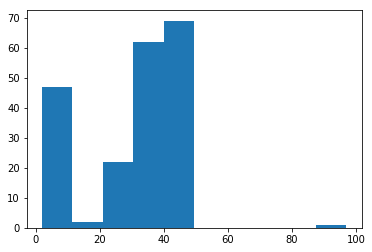

In [52]:
plt.hist(dd[NUM_ERROR_REACTIONS])

In [62]:
extended_res_df.head()

error_type         model_id  num_error_reactions  num_nonbdry_reactions  \
0      type1  BIOMD0000000189                    1                     13   
1      type1  BIOMD0000000189                    1                     13   
2      type1  BIOMD0000000189                    1                     13   
3      type1  BIOMD0000000189                    3                     13   
4      type1  BIOMD0000000413                    3                      5   

   num_total_reactions      niss  
0                   14  0.076923  
1                   14  0.076923  
2                   14  0.076923  
3                   14  0.230769  
4                    9  0.600000

In [67]:
final_res_df = extended_res_df.rename(columns = {NUM_ERROR_REACTIONS:"iss"})
final_res_df.head()

error_type         model_id  iss  num_nonbdry_reactions  \
0      type1  BIOMD0000000189    1                     13   
1      type1  BIOMD0000000189    1                     13   
2      type1  BIOMD0000000189    1                     13   
3      type1  BIOMD0000000189    3                     13   
4      type1  BIOMD0000000413    3                      5   

   num_total_reactions      niss  
0                   14  0.076923  
1                   14  0.076923  
2                   14  0.076923  
3                   14  0.230769  
4                    9  0.600000

In [70]:
final_res_df.to_csv("/Users/woosubshin/Desktop/ModelEngineering/results/games_statistics.csv", index=False)

In [17]:
print("Number of models with errors: %d" % (len(set(res_df[MODEL_ID]))))

Number of models with errors: 140


In [71]:
# plt.scatter(res_df[NUM_TOTAL_REACTIONS], res_df[NUM_ERROR_REACTIONS])

In [72]:
# plt.hist(res_df[NUM_TOTAL_REACTIONS] - res_df[NUM_NONBDRY_REACTIONS], bins=100)

In [73]:
# plt.scatter(res_df[NUM_NONBDRY_REACTIONS], res_df[NUM_ERROR_REACTIONS])

In [74]:
type1_res_df = res_df[res_df[ERROR_TYPE] == TYPE_I]
type2_res_df = res_df[res_df[ERROR_TYPE] == TYPE_II]
type3_res_df = res_df[res_df[ERROR_TYPE] == TYPE_III]
canceling_res_df = res_df[res_df[ERROR_TYPE] == CANCELING]
echelon_res_df = res_df[res_df[ERROR_TYPE] == ECHELON]

In [75]:
# type1_res_df.head()

In [76]:
#plt.scatter(type1_res_df[NUM_NONBDRY_REACTIONS], type1_res_df[NUM_ERROR_REACTIONS])

In [77]:
#plt.scatter(type2_res_df[NUM_NONBDRY_REACTIONS], type2_res_df[NUM_ERROR_REACTIONS])

In [78]:
#plt.scatter(type3_res_df[NUM_NONBDRY_REACTIONS], type3_res_df[NUM_ERROR_REACTIONS])

In [79]:
#plt.scatter(canceling_res_df[NUM_NONBDRY_REACTIONS], canceling_res_df[NUM_ERROR_REACTIONS])

In [80]:
#plt.scatter(echelon_res_df[NUM_NONBDRY_REACTIONS], echelon_res_df[NUM_ERROR_REACTIONS])

In [28]:
#res_list

In [29]:
prop = res_df["num_error_reactions"] / res_df["num_nonbdry_reactions"]
error_prop = prop[prop > 1]
nonerror_prop = prop[prop<=1]
print("error_prop", error_prop)

error_prop Series([], dtype: float64)


Text(0, 0.5, 'Cumulative Probability')

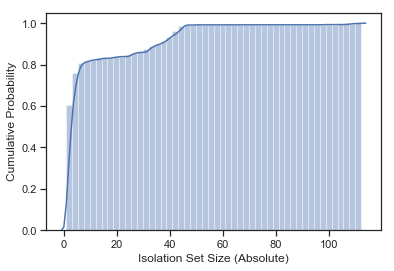

In [130]:
sns.set(style="white",
        font='Times New Roman',
        rc={'figure.figsize':(6,4)})
sns.set_style("ticks")
cdf_abs = sns.distplot(final_res_df["iss"],
             bins=50,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.xlabel("Isolation Set Size (Absolute)")
plt.ylabel("Cumulative Probability")

In [131]:
output_cdf_abs = cdf_abs.get_figure()
output_cdf_abs.savefig("/Users/woosubshin/Desktop/ModelEngineering/figures_tables/cdf_abs.png")

Text(0, 0.5, 'Cumulative Probability')

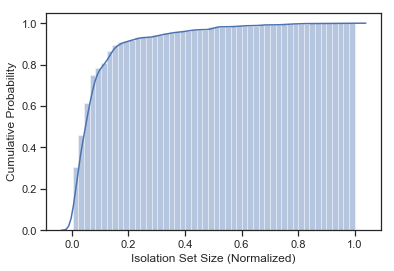

In [133]:
cdf_norm = sns.distplot(final_res_df["niss"],
             hist_kws=dict(cumulative=True),
             bins=50,
             kde_kws=dict(cumulative=True))
plt.xlabel("Isolation Set Size (Normalized)")
plt.ylabel("Cumulative Probability")

In [134]:
output_cdf_norm = cdf_norm.get_figure()
output_cdf_norm.savefig("/Users/woosubshin/Desktop/ModelEngineering/figures_tables/cdf_norm.png")

Text(0, 0.5, 'Frequency')

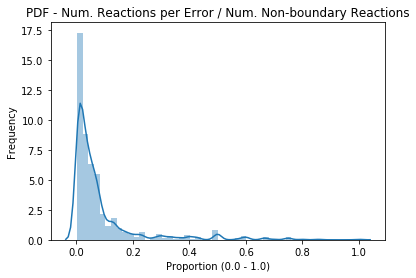

In [33]:
sns.distplot(prop,
             hist_kws=dict(cumulative=False),
             kde_kws=dict(cumulative=False))
plt.title("PDF - Num. Reactions per Error / Num. Non-boundary Reactions")
plt.xlabel("Proportion (0.0 - 1.0)")
plt.ylabel("Frequency")

Text(0, 0.5, 'Cumulative probability')

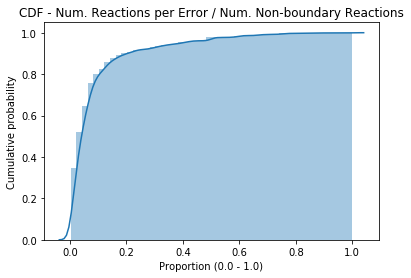

In [34]:
sns.distplot(prop,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.title("CDF - Num. Reactions per Error / Num. Non-boundary Reactions")
plt.xlabel("Proportion (0.0 - 1.0)")
plt.ylabel("Cumulative probability")

Text(0, 0.5, 'Probability')

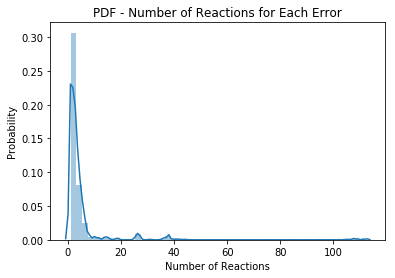

In [41]:
sns.distplot(res_df[NUM_ERROR_REACTIONS],
             hist_kws=dict(cumulative=False),
             kde_kws=dict(cumulative=False))
plt.title("PDF - Number of Reactions for Each Error")
plt.xlabel("Number of Reactions")
plt.ylabel("Probability")

Text(0, 0.5, 'Cumulative probability')

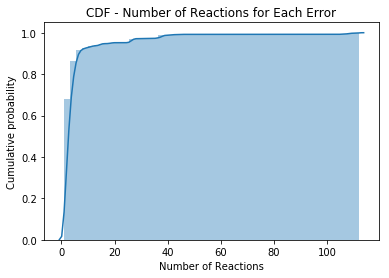

In [39]:
sns.distplot(res_df[NUM_ERROR_REACTIONS],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.title("CDF - Number of Reactions for Each Error")
plt.xlabel("Number of Reactions")
plt.ylabel("Cumulative probability")

In [49]:
len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]) / len(res_df[NUM_ERROR_REACTIONS])

0.6804123711340206

In [51]:
len(res_df[NUM_ERROR_REACTIONS])

873

In [55]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]) / len(res_df[NUM_ERROR_REACTIONS]))

594
0.6804123711340206


In [56]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 5]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 5]) / len(res_df[NUM_ERROR_REACTIONS]))

752
0.861397479954181


In [57]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 10]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 10]) / len(res_df[NUM_ERROR_REACTIONS]))

813
0.9312714776632303


In [71]:
res_df.loc[170:180]

error_type         model_id  num_error_reactions  num_nonbdry_reactions  \
170      type1  BIOMD0000000297                    4                     22   
171      type1  BIOMD0000000297                    5                     22   
172      type1  BIOMD0000000356                    5                     63   
173      type1  BIOMD0000000356                    6                     63   
174      type1  BIOMD0000000356                    6                     63   
175      type1  BIOMD0000000356                    6                     63   
176      type1  BIOMD0000000356                    7                     63   
177    echelon  BIOMD0000000426                    3                     29   
178    echelon  BIOMD0000000426                    8                     29   
179    echelon  BIOMD0000000105                    3                     94   
180      type3  BIOMD0000000628                   13                    584   

     num_total_reactions  
170                   51  
171                   51  
172                   64  
173                   64  
174                   64  
175                   64  
176                   64  
177                   29  
178                   29  
179                   94  
180                  587

In [38]:
for i, m in enumerate(files):
  if m[:-8] == "BIOMD0000000014":
    print("index of model 14 is", i)

index of model 14 is 157


In [39]:
files[156]

'BIOMD0000000362_url.xml'

In [61]:
import time
# Checking all graphs 
simple = SimpleSBML()
count = 0
res_list2 = []
start = time.time()
for file in files[140:170]:
  count += 1
  if (count%100)==0:
    print("we are analyzing Model number:", count)
  try:
    simple.initialize(os.path.join(data_dir, file))
    m = GAMES_PP(simple)
    s = StoichiometryMatrix(simple)
    num_total_reactions = len(simple.reactions)
    num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
    if simple.reactions:
      result = m.analyze(error_details=False)
      if result:
        gr = GAMESReport(m)
        errortype_dic = {TYPE_I: gr.reportTypeOneError,
                         TYPE_II: gr.reportTypeTwoError,
                         TYPE_III: gr.reportTypeThreeError,
                         CANCELING: gr.reportCancelingError,
                         ECHELON: gr.reportEchelonError
                        }
        summary = m.error_summary
        for errors_type in m.error_summary:
          for category in errortype_dic.keys():
            if errors_type.type == category:
              func = errortype_dic[category]            
              _, error_num = func(errors_type.errors)
              for num in error_num:
                dic = {}
                dic[MODEL_ID] = file[:-8]
                dic[NUM_TOTAL_REACTIONS] = num_total_reactions
                dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
                dic[ERROR_TYPE] = category
                dic[NUM_ERROR_REACTIONS] = num
                res_list2.append(dic)
#                 res_list2.append({MODEL_ID: file[:-8],
#                                   NUM_TOTAL_REACTIONS: num_total_reactions,
#                                   NUM_NONBDRY_REACTIONS: num_nonbdry_reactions,
#                                   ERROR_TYPE: category,
#                                   NUM_ERROR_REACTIONS: num})
#                 print("model dic number", dic[MODEL_ID])
#                 print("res_dic", res_dic)
  except:
    print("Model", file, " has an error")
end = time.time()
print("elapsed time:", end - start)

elapsed time: 3.8915278911590576


In [57]:
res_list2

[{'model_id': 'BIOMD0000000494',
  'num_total_reactions': 71,
  'num_nonbdry_reactions': 71,
  'error_type': 'type1',
  'num_error_reactions': 5},
 {'model_id': 'BIOMD0000000494',
  'num_total_reactions': 71,
  'num_nonbdry_reactions': 71,
  'error_type': 'type1',
  'num_error_reactions': 3},
 {'model_id': 'BIOMD0000000494',
  'num_total_reactions': 71,
  'num_nonbdry_reactions': 71,
  'error_type': 'type1',
  'num_error_reactions': 3},
 {'model_id': 'BIOMD0000000494',
  'num_total_reactions': 71,
  'num_nonbdry_reactions': 71,
  'error_type': 'type1',
  'num_error_reactions': 5},
 {'model_id': 'BIOMD0000000623',
  'num_total_reactions': 31,
  'num_nonbdry_reactions': 31,
  'error_type': 'type1',
  'num_error_reactions': 3},
 {'model_id': 'BIOMD0000000268',
  'num_total_reactions': 61,
  'num_nonbdry_reactions': 47,
  'error_type': 'type1',
  'num_error_reactions': 2},
 {'model_id': 'BIOMD0000000268',
  'num_total_reactions': 61,
  'num_nonbdry_reactions': 47,
  'error_type': 'type1',
